In [24]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

In [25]:
# ALL REGEX PATTERNS (✅ good)
RE_GPU_COUNT = re.compile(r"Network initialized successfully for (\d+) GPU\(s\)!")
RE_NX = re.compile(r"global nx\s*\.*\s*(\d+)")
RE_NY = re.compile(r"global ny\s*\.*\s*(\d+)")
RE_NZ = re.compile(r"global nz\s*\.*\s*(\d+)")
RE_NSPECIES = re.compile(r"Number of all species\s*(\d+)")
RE_PPC = re.compile(r"\bParticles\s*\.*\s*(\d+)\s*\[ppc\]")
RE_EXTRA_PARTICLES = re.compile(r"Extra particles\s*\.*\s*\+\S+\s*([\d.]+)")
RE_PART_MEM = re.compile(r"Total particle memory on\s+(HOST)\s+([0-9.]+)\s*MB\s*/\s*GPU")
RE_FIELD_MEM = re.compile(r"Total field\s+memory on\s+(HOST)\s+([0-9.]+)\s*MB\s*/\s*GPU")
RE_VERSION = re.compile(r"Version\s+(\d{4}-\d{2}-\d{2})")  # ✅ Added here

def parse_job_out(path: Path) -> dict:
    d = {
        "file": path.name,
        "n_gpu": np.nan,
        "nx": np.nan, "ny": np.nan, "nz": np.nan,
        "nspecies": np.nan,
        "sum_ppc": 0, "n_ppc_lines": 0,
        "extra_particles_pct": 0.0,
        "particle_mem_host_mb_per_gpu": np.nan,
        "particle_mem_device_mb_per_gpu": np.nan,
        "field_mem_host_mb_per_gpu": np.nan,
        "field_mem_device_mb_per_gpu": np.nan,
    }
    
    with path.open("r", errors="replace") as f:
        for line in f:
            # GPU count
            if np.isnan(d["n_gpu"]):
                m = RE_GPU_COUNT.search(line)
                if m:
                    d["n_gpu"] = int(m.group(1))
                    continue
            
            # Grid dimensions
            if np.isnan(d["nx"]):
                m = RE_NX.search(line)
                if m:
                    d["nx"] = int(m.group(1))
                    continue
            
            if np.isnan(d["ny"]):
                m = RE_NY.search(line)
                if m:
                    d["ny"] = int(m.group(1))
                    continue
            
            if np.isnan(d["nz"]):
                m = RE_NZ.search(line)
                if m:
                    d["nz"] = int(m.group(1))
                    continue
            
            if np.isnan(d["nspecies"]):
                m = RE_NSPECIES.search(line)
                if m:
                    d["nspecies"] = int(m.group(1))
                    continue
            
            # PPC per species
            m = RE_PPC.search(line)
            if m:
                d["sum_ppc"] += int(m.group(1))
                d["n_ppc_lines"] += 1
                continue
            
            # Extra particles
            m = RE_EXTRA_PARTICLES.search(line)
            if m:
                d["extra_particles_pct"] = float(m.group(1))
                continue
            
            # Particle memory
            m = RE_PART_MEM.search(line)
            if m:
                where = m.group(1)
                val = float(m.group(2))
                key = "particle_mem_host_mb_per_gpu" if where == "HOST" else "particle_mem_device_mb_per_gpu"
                d[key] = val
                continue
            
            # Field memory
            m = RE_FIELD_MEM.search(line)
            if m:
                where = m.group(1)
                val = float(m.group(2))
                key = "field_mem_host_mb_per_gpu" if where == "HOST" else "field_mem_device_mb_per_gpu"
                d[key] = val
                continue
    
    return d

In [26]:
# =====================================================
# ONE CONSISTENT PIPELINE:
LOG_DIR = Path("/Users/jeremiassiehr/Documents/jobscripts")
MEM_SRC = "device"
STRICT_MODE = True
REJECT_VERSION = "2024-01-26"

paths = sorted(LOG_DIR.glob("job*.out"))
print(f"Found {len(paths)} files")

# 1. Parse raw data
df = pd.DataFrame(parse_job_out(p) for p in paths)

# 2. Extract versions
def extract_version(path: Path) -> str:
    try:
        with path.open("r", errors="replace") as f:
            for line in f:
                m = RE_VERSION.search(line)
                if m: return m.group(1)
    except: pass
    return "unknown"
df["version"] = [extract_version(p) for p in paths]

# 3. Geometry (NO extra particles bias)
df["nxnyz"] = df.nx * df.ny * df.nz
df["geom_particles"] = df.nxnyz * df.sum_ppc
df["geom_fields"] = df.nxnyz

# 4. Total memory
if MEM_SRC.lower() == "device":
    df["M_particles_tot_mb"] = df.particle_mem_device_mb_per_gpu * df.n_gpu
    df["M_fields_tot_mb"] = df.field_mem_device_mb_per_gpu * df.n_gpu
else:
    df["M_particles_tot_mb"] = df.particle_mem_host_mb_per_gpu * df.n_gpu
    df["M_fields_tot_mb"] = df.field_mem_host_mb_per_gpu * df.n_gpu

# 5. SINGLE FILTER BLOCK - ALL CRITERIA
mask_core = df[["n_gpu","nx","ny","nz","nspecies"]].notna().all(axis=1)
mask_ppc = df["sum_ppc"] > 0
mask_version = df["version"] != REJECT_VERSION
mask_strict = (df["n_ppc_lines"] == df["nspecies"]) if STRICT_MODE else True

df_fit = df[mask_core & mask_ppc & mask_version & mask_strict].copy()

# 6. Summary
print(f"🚫 Rejected {len(df[df.version==REJECT_VERSION])} × {REJECT_VERSION}")
print(f"✅ Usable: {len(df_fit)}/{len(paths)} files (STRICT={STRICT_MODE})")
print(f"📊 Versions: {df_fit.version.value_counts().to_dict()}")
print(f"   nspecies: {df_fit.nspecies.min():.0f}–{df_fit.nspecies.max():.0f}")
print(f"   sum_ppc:  {df_fit.sum_ppc.min():.0f}–{df_fit.sum_ppc.max():.0f}")
df_fit[["file","n_gpu","nspecies","sum_ppc","version","M_particles_tot_mb","M_fields_tot_mb"]].head()

Found 886 files
🚫 Rejected 577 × 2024-01-26
✅ Usable: 97/886 files (STRICT=True)
📊 Versions: {'2025-01-16': 88, '2025-12-09': 7, '2025-05-12': 2}
   nspecies: 1–4
   sum_ppc:  1–48


,file,n_gpu,nspecies,sum_ppc,version,M_particles_tot_mb,M_fields_tot_mb
788,job_30380468.out,4.0,1.0,16,2025-05-12,NaN,NaN
789,job_32043425.out,8.0,1.0,16,2025-05-12,NaN,NaN
790,job_35068902.out,1.0,1.0,1,2025-01-16,NaN,NaN
791,job_35069708.out,1.0,1.0,1,2025-01-16,NaN,NaN
792,job_35296250.out,1.0,1.0,1,2025-01-16,NaN,NaN


In [27]:
def fit_through_origin(x, y):
    x, y = np.asarray(x, float), np.asarray(y, float)
    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    if len(x) < 2: 
        return np.nan, np.nan, np.nan
    
    # Slope through origin
    m = np.dot(x, y) / np.dot(x, x)
    yhat = m * x
    
    # *** FIXED R² for through-origin: compare to y=0 baseline ***
    ss_res = np.sum((y - yhat)**2)           # Residuals vs fit line
    ss_tot = np.sum(y**2)                    # Total vs ORIGIN (y=0)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    # Standard error
    resid = y - yhat
    se = np.sqrt(np.dot(resid, resid) / (len(x)-1) / np.dot(x, x))
    return m, se, r2

A, A_se, A_r2 = fit_through_origin(df_fit["geom_particles"], df_fit["M_particles_tot_mb"])
B, B_se, B_r2 = fit_through_origin(df_fit["geom_fields"], df_fit["M_fields_tot_mb"])

print(f"📊 RESULTS ({MEM_SRC}, excluded 2024-01-26):")
print(f"   A = {A:.8g} ± {A_se:.3g} MB  (R² = {A_r2:.4f})")
print(f"   B = {B:.8g} ± {B_se:.3g} MB  (R² = {B_r2:.4f})")

📊 RESULTS (device, excluded 2024-01-26):
   A = nan ± nan MB  (R² = nan)
   B = nan ± nan MB  (R² = nan)


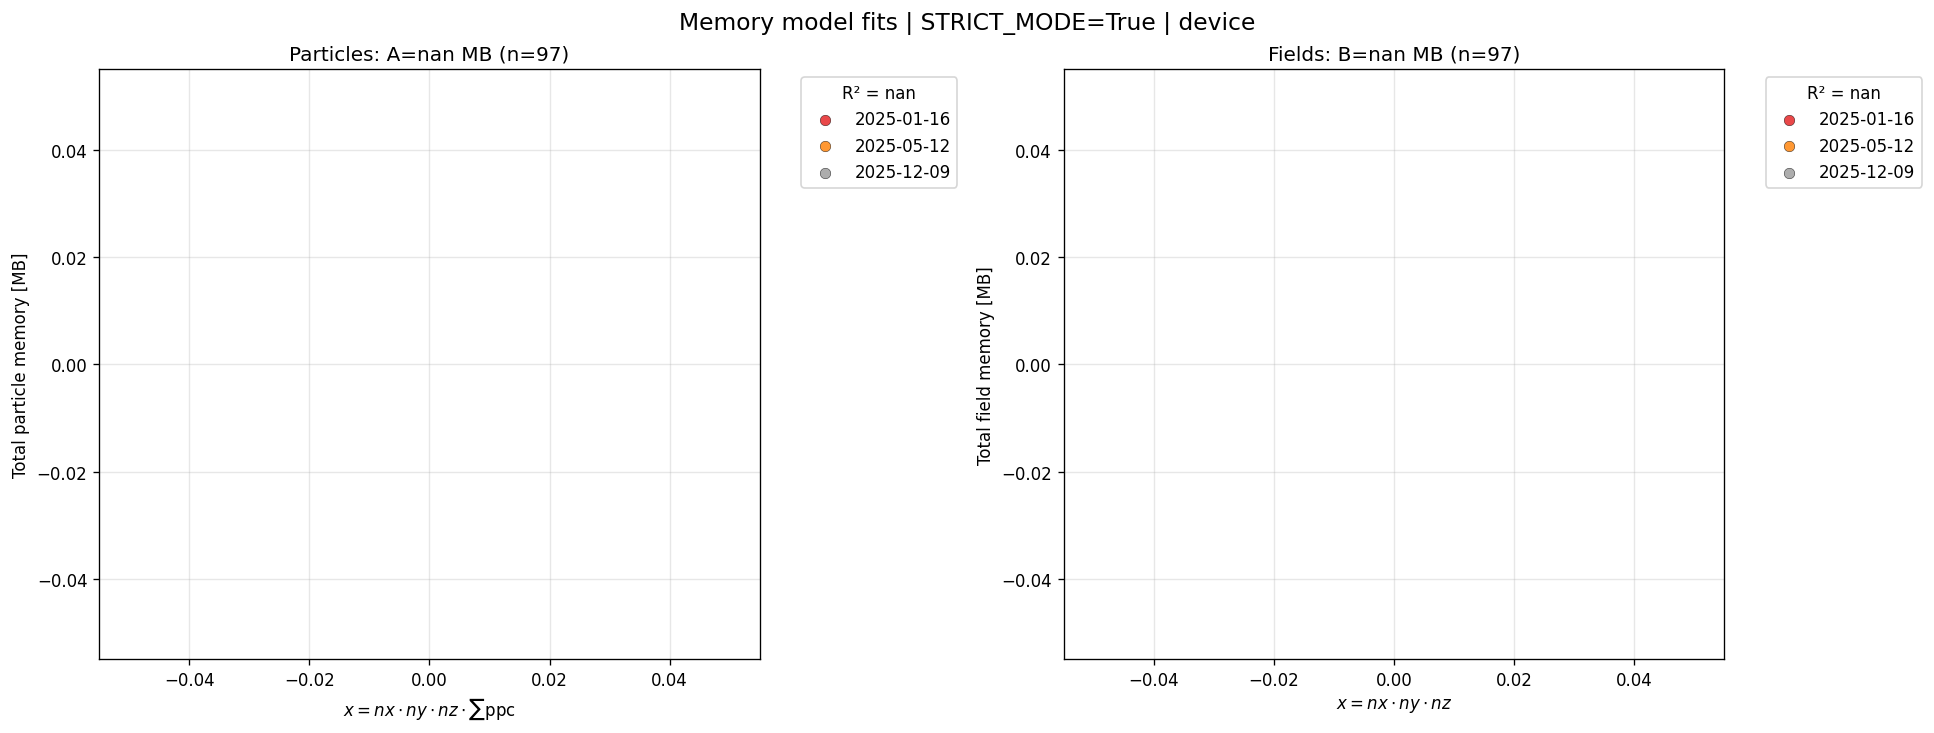

In [28]:
def plot_fit_by_version(ax, x, y, slope, r2, versions, title, xlabel, ylabel):
    unique_versions = sorted(versions.unique())
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_versions)))
    version_to_color = dict(zip(unique_versions, colors))
    
    # Scatter by version
    for version in unique_versions:
        mask = versions == version
        ax.scatter(x[mask], y[mask], s=40, alpha=0.8, 
                  c=[version_to_color[version]], label=version,
                  edgecolors='k', linewidth=0.3)
    
    ax.grid(True, alpha=0.3)
    
    if np.isfinite(slope) and len(x):
        xs = np.linspace(0, x.max()*1.05, 200)
        ax.plot(xs, slope * xs, 'k-', linewidth=3, 
                label=f'Fit: {slope:.3g}')
    
    # *** ADD R² to legend title ***
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
              title=f'R² = {r2:.4f}')

# Updated plot call
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

plot_fit_by_version(axes[0], df_fit["geom_particles"], df_fit["M_particles_tot_mb"], 
                   A, A_r2, df_fit["version"],
                   f'Particles: A={A:.3g} MB (n={len(df_fit)})',
                   r'$x = nx\cdot ny\cdot nz\cdot \sum\mathrm{ppc}$', 
                   'Total particle memory [MB]')

plot_fit_by_version(axes[1], df_fit["geom_fields"], df_fit["M_fields_tot_mb"], 
                   B, B_r2, df_fit["version"],
                   f'Fields: B={B:.3g} MB (n={len(df_fit)})', 
                   r'$x = nx\cdot ny\cdot nz$', 
                   'Total field memory [MB]')

plt.suptitle(f'Memory model fits | STRICT_MODE={STRICT_MODE} | {MEM_SRC}', fontsize=14)
plt.show()

In [29]:
# =====================================================
# MAXIMUM MEMORY ESTIMATOR
# =====================================================

print("🧮 MAXIMUM MEMORY ESTIMATOR")
print("=" * 60)

# YOUR INPUTS
NX, NY, NZ = 320, 560, 560
NSPECIES = 1
PPC = 10
NGPU = 2
OVERHEAD = 1.01

# Calculations
nxnyz = NX * NY * NZ
total_ppc = NSPECIES * PPC

# TOTAL memory (MB)
M_particles_tot_mb = A * nxnyz * total_ppc
M_fields_tot_mb = B * nxnyz
M_total_tot_mb = M_particles_tot_mb + M_fields_tot_mb

# ✅ FIXED: Convert MB→GB THEN divide by GPUs
M_total_tot_gb = M_total_tot_mb / 1000 * OVERHEAD
M_per_gpu_gb = M_total_tot_gb / NGPU

print(f"📐 GRID:      {NX}×{NY}×{NZ} = {nxnyz:,.0f} cells")
print(f"⚡ PARTICLES: {NSPECIES} species × {PPC} ppc = {total_ppc} ppc/cell")
print(f"💻 GPUS:      {NGPU}")
print()
print(f"💾 TOTAL MEMORY:")
print(f"   Particles: {M_particles_tot_mb/1000*OVERHEAD:.1f} GB")
print(f"   Fields:    {M_fields_tot_mb/1000*OVERHEAD:.1f} GB")
print(f"   TOTAL:     {M_total_tot_gb:.1f} GB")
print()
print(f"🔢 PER-GPU:")
print(f"   TOTAL:     {M_per_gpu_gb:.1f} GB/GPU (incl. {OVERHEAD*100-100:.0f}% overhead)")
print()
print("✅ SAFE:  < 40 GB/GPU (A40)")
print("⚠️  WARN: 40-44 GB/GPU")
print("❌ DANGER: >45 GB/GPU")
print()
print(f"🎯 RESULT: {M_per_gpu_gb:.1f} GB/GPU → {'✅ SAFE' if M_per_gpu_gb<40 else '⚠️  MARGIN' if M_per_gpu_gb<45 else '❌ OOM'}")


🧮 MAXIMUM MEMORY ESTIMATOR
📐 GRID:      320×560×560 = 100,352,000 cells
⚡ PARTICLES: 1 species × 10 ppc = 10 ppc/cell
💻 GPUS:      2

💾 TOTAL MEMORY:
   Particles: nan GB
   Fields:    nan GB
   TOTAL:     nan GB

🔢 PER-GPU:
   TOTAL:     nan GB/GPU (incl. 1% overhead)

✅ SAFE:  < 40 GB/GPU (A40)
⚠️  WARN: 40-44 GB/GPU
❌ DANGER: >45 GB/GPU

🎯 RESULT: nan GB/GPU → ❌ OOM
